# Workshop 2 - ArcGIS Survey 123 data analysis

In [385]:
# using Python to initialize GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image
import pandas as pd

# create GRASS GIS runtime environment
gisbase = "/usr/local/grass79" #subprocess.check_output(["grass79", "--config", "path"], text=True).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# do GRASS GIS imports
import grass.script as gs
import grass.script.setup as gsetup

# set GRASS GIS session data
# rcfile = gsetup.init(gisbase, "/home/jovyan/grassdata", "nc_spm_08_grass7", "user1")
rcfile = gsetup.init(gisbase, "/home/coreywhite/Documents/grassdata", "wrri_nad83_6542", "tomorrownow")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Define Varibales

In [492]:
survey ="surveyPoint@PERMANENT"
w2_survey_results = "w2_survey_results"

# QL2 DEM
dem = "dem_10m_mosaic@wrri10m"
hillshade = "dem_10m_hillshade"

# Political Boundaries
nc_state = "nc_state@PERMANENT"
research_triangle = "ResearchTriangle@PERMANENT"
research_triangle_core = "ResearchTriangleCore@PERMANENT"

# Hydrological Boundaries
huc_12 = "wbd_huc_10_12@PERMANENT"
research_triangle_huc12 = "research_triangle_huc12"
watersheds = "watersheds_huc_10@wrri10m"
basins = "basins_huc_8@wrri10m"

# Derived Hydro Features
direction = "direction_3k"
basins = "basin_3k"
streams = "streams_3k"
accumulation = "accum_3k"
topidx = "topidx_10m"
inundation = "1m_inundation"
extracted_streams = "streams_3k_ext"



#Land Cover
lcmap_2017 = "LCMAP_CU_2017_V01_LCPRI@PERMANENT"
nlcd_2016 = "NLCD_2016_Land_Cover_L48_20190424@PERMANENT"
nlcd_2016_blend = "nlcd_2016_blend"


In [430]:
nlcd_class_map ={
    11: "Open Water",
    21: "Developed (Open Space)",
    22: "Developed (Low Intensity)",
    23: "Developed (Medium Intensity)",
    24: "Developed (High Intensity)",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

nlcd_top_level_class_map ={
    11: "Water",
    21: "Developed",
    22: "Developed",
    23: "Developed",
    24: "Developed",
    31: "Barren",
    41: "Forest",
    42: "Forest",
    43: "Forest",
    51: "Shrubland",
    52: "Shrubland",
    71: "Herbaceous",
    81: "Planted/Cultivated",
    82: "Planted/Cultivated",
    90: "Wetlands",
    95: "Wetlands"
}

## Set Computational Region

In [5]:
gs.parse_command('g.region', vector=research_triangle, res=10, flags='pg')


{'projection': '99',
 'zone': '0',
 'n': '310235.5555',
 's': '167250.0967',
 'w': '559202.8574',
 'e': '698392.8363',
 'nsres': '9.99968241',
 'ewres': '9.99999848',
 'rows': '14299',
 'cols': '13919',
 'cells': '199027781'}

### Create layer of subwatersheds that overlap the Triangle

In [ ]:
gs.run_command("v.select",
    overwrite=True, 
    ainput=huc_12, 
    binput=research_triangle, 
    output=research_triangle_huc12, 
    operator="overlap")

### Reset computational region to the subwatersheds that overlap the Triangle

In [151]:
#Set computational region and mask
gs.parse_command('g.region', raster=dem, res=10, flags='pg')
gs.run_command("r.mask", vector=research_triangle_huc12)

## Calculate Flow Direction
gs.run_command("r.watershed",
    overwrite=True,
    flags="m",
    elevation=dem, 
    threshold=3000,
    accumulation=accumulation,
    drainage=direction,
    basin=basins,
    stream=streams,
    convergence=5,
    memory=10000       
)

In [177]:
# gs.run_command("r.mask", flags="r")
# gs.parse_command('g.region', raster=dem, res=10, flags='pg')
# gs.run_command("r.mask", vector=research_triangle_huc12)


gs.run_command("r.stream.extract",
    overwrite=True,
    elevation=dem,
    accumulation=accumulation,
    threshold=3000,
    mexp=0,
    stream_length=0,
    memory=10000,
    stream_raster=extracted_streams, 
    stream_vector=extracted_streams)

In [471]:
gs.run_command('g.region', raster=dem, res=10, flags='pg')
# gs.run_command("r.mask", flags="r")
gs.run_command("r.mask", vector=research_triangle_huc12, overwrite=True)
gs.run_command("r.topidx", input=dem, output=topidx, overwrite=True)

In [ ]:
gs.parse_command('g.region', vector=research_triangle_huc12, res=10, flags='pg')
gs.parse_command("v.info", map=research_triangle_huc12)

### Set a compuational mask to the subwatersheds that overlap the Triangle

## Create a new feature containing only survey points added during Workshop 2

In [ ]:
# Filter survey results to the day of Workshop 2
gs.run_command("v.extract", overwrite=True, input=survey, where="CreationDa = '2019-04-12'", output=w2_survey_results)
gs.parse_command("v.info", map=w2_survey_results)
gs.parse_command("v.info", map=w2_survey_results, flags="c")

The featureset should now contain 31 points

### Identify spatial clusters in the survey data

In [7]:
# Indetify clusters from the survey using the density algorithm 
w2_survey_clusters = "w2_survey_clusters"
gs.parse_command('g.region', vector=w2_survey_clusters, res=10, flags='pg')
gs.run_command("v.cluster", overwrite=True, verbose=True, input=w2_survey_results, output=w2_survey_clusters, layer=2, distance=1000, min=3, method="dbscan")

Three clusters should be identified with a fourth group defined as group -1 which is the remaining unclustered points

### Extrat each cluster into its own feature

In [362]:
gs.parse_command('g.region', raster=direction, res=10, flags='pg')
gs.run_command("r.mask", flags="r")
gs.run_command("r.mask", vector=research_triangle_huc12)

cluster_ids = [1,2,3]
clusters = []
cluster_centerpoints = []
cluster_outlets = []
cluster_contributing_areas = []
cluster_drain = []
hulls = []
cluster_huc12s = []
cluster_huc10s = []
for c in cluster_ids:
    
    # Extract the cluster from the cluster output
    output = "cluster_{}".format(c)
    clusters.append(output)
    gs.run_command('v.extract', 
        overwrite=True, 
        input=w2_survey_clusters, 
        layer=2, 
        type="point", 
        cats=c, 
        output=output)
   
    # Generate a convex hull for the cluster
    output_hull = "{}_hull".format(output)
    hulls.append(output_hull)
    gs.run_command('v.hull', 
        overwrite=True, 
        input=output, 
        layer=2, 
        output=output_hull)

    # Select subwatersheds containing cluster
    cluster_huc12s_output = "{}_huc_12".format(output)
    cluster_huc12s.append(cluster_huc12s_output)
    gs.run_command("v.select", 
        ainput=huc_12, 
        binput=output, 
        blayer=2, 
        output=cluster_huc12s_output, 
        operator="overlap")
    
    # Select watersheds containing cluster
    cluster_huc10s_output = "{}_huc_10".format(output)
    cluster_huc10s.append(cluster_huc10s_output)
    gs.run_command("v.select", 
        ainput=watersheds, 
        binput=output, 
        blayer=2, 
        output=cluster_huc10s_output, 
        operator="overlap")

    # Create Cluster Center Point
    centerpoints = "{}_centerpoint".format(output)
    cluster_centerpoints.append(centerpoints)
    gs.run_command("v.centerpoint",
         input=output,
         layer=2,
         type="point", 
         output=centerpoints,
         acenter="median", 
         overwrite=True)

    # Snap Cluster Center Point to Stream
    outlet = "{}_outlet".format(output)
    cluster_outlets.append(outlet)
    gs.run_command("r.stream.snap",
        overwrite=True,
        input=output, 
        output=outlet, 
        stream_rast=streams, 
        accumulation=accumulation,
        radius=100,
        memory=10000,
        threshold=10000
    )

    # Calculate Contributing Area
    contributing_area = "{}_contrib_area".format(output)
    cluster_contributing_areas.append(contributing_area)
    gs.run_command("r.stream.basins",
        direction=direction,
        points=outlet,
        memory=10000,
        basins=contributing_area
    )

    # Convert to vector for displaying
    gs.run_command("r.to.vect", overwrite=True, input=contributing_area, output=contributing_area, type="area")

    # Calculate Drainage
    drainage = "{}_drainage".format(output)
    cluster_drain.append(drainage)
    drain_dir = "direction_deg_3k"
    gs.run_command("r.mapcalc", 
        expression="{} = if({} != 0, 45. * abs({}), null())".format(drain_dir,direction, direction),
        overwrite=True)
    gs.run_command("r.drain",
        input=dem,
        direction=drain_dir,
        output=drainage, 
        drain=drainage, 
        start_points=outlet)






## Map of all clusters center points

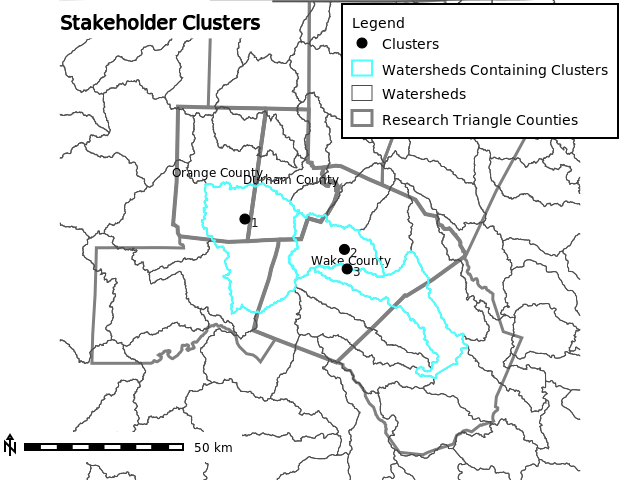

In [106]:
gs.run_command("r.mask", flags="r")
gs.run_command("r.mask", vector=research_triangle_huc12)
gs.parse_command('g.region', vector=research_triangle_huc12, res=10, flags='pg')
gs.run_command('d.erase')
# gs.run_command('d.rast', map=nlcd_2016)
gs.run_command('d.vect', map=research_triangle, color="grey", fill_color="none", width=3)
gs.run_command('d.vect', map=research_triangle_core, color="grey", fill_color="none", width=4, attribute_column="COUNTY", label_color="black", label_size=12, xref="center")

# gs.run_command('d.vect', map=basins, color="26:26:26:255", fill_color="none", width=3) #"191:191:191:255"
gs.run_command('d.vect', map=watersheds, color="77:77:77:255", fill_color="none", width=1) #"191:191:191:255"
# gs.run_command('d.vect', map=research_triangle_huc12, color="77:77:77:255", fill_color="none", width=1) #
gs.run_command('d.vect', map=cluster_huc10s[0], color="77:255:255:255", fill_color="none", width=2)
gs.run_command('d.vect', map=cluster_huc10s[1], color="77:255:255:255", fill_color="none", width=2)
gs.run_command('d.vect', map=cluster_huc10s[2], color="77:255:255:255", fill_color="none", width=2)

# gs.run_command('d.vect', map=streams)
gs.run_command('d.vect', map=cluster_centerpoints[0], icon="basic/point", layer=2, display="shape,cat",label_layer=2, label_color="26:26:26:255", label_size=12, size=20, color="black", fill_color="black")
gs.run_command('d.vect', map=cluster_centerpoints[1], icon="basic/point", layer=2, display="shape,cat",label_layer=2, label_color="26:26:26:255", label_size=12, size=20, color="black", fill_color="black")
gs.run_command('d.vect', map=cluster_centerpoints[2], icon="basic/point", layer=2, display="shape,cat",label_layer=2, label_color="26:26:26:255", label_size=12, size=20, color="black", fill_color="black")


# gs.run_command('d.vect', map=hulls[2])
gs.run_command('d.text', text="Stakeholder Clusters", size="5", color="0:0:0:255", flags="b",bgcolor="255:255:255:255",at="0,94")
gs.run_command('d.barscale', flags='n')
gs.run_command('d.legend.vect', 
    input="./figures/all_clusters_legend.txt", 
    bgcolor="255:255:255:255", 
    border_color="0:0:0:255", 
    title="Legend",
    at="55,99",
    flags="b")
# gs.run_command('d.legend', raster=nlcd_2016)
Image(filename="map.png")

In [324]:
def mapCluster(clusterId, title=""):
    gs.run_command("r.mask", flags="r")
    gs.run_command("r.mask", vector=cluster_huc10s[clusterId])
    gs.parse_command('g.region', vector=cluster_huc10s[clusterId], res=10, flags='pg')

    gs.run_command('d.erase')
    # gs.run_command('d.rast', map=nlcd_2016)
    gs.run_command("r.colors", map=cluster_contributing_areas[clusterId], rules="./figures/contributing_area_color.txt")
    gs.run_command('d.rast', map=cluster_contributing_areas[clusterId])
    # gs.run_command('d.rast', map=streams)



    gs.run_command('d.vect', map=research_triangle, color="grey", fill_color="none", width=3)
    gs.run_command('d.vect', map=research_triangle_core, color="grey", fill_color="none", width=4, attribute_column="COUNTY", label_color="black", label_size=12, xref="center")

    # gs.run_command('d.vect', map=basins, color="26:26:26:255", fill_color="none", width=3) #"191:191:191:255"
    gs.run_command('d.vect', map=cluster_huc10s[clusterId], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"
    gs.run_command('d.vect', map=cluster_huc12s[clusterId], color="77:255:255:255", fill_color="none", width=4) #

    
    gs.run_command('d.vect', map=cluster_drain[clusterId], color="blue")
    gs.run_command('d.vect', map=cluster_outlets[clusterId], icon="basic/point",fill_color="black", layer=2, size=20)

    gs.run_command('d.barscale', flags='n')
    gs.run_command('d.legend.vect', 
        input="./figures/cluster_{}_legend.txt".format(clusterId + 1), 
        bgcolor="255:255:255:255", 
        border_color="0:0:0:255", 
        fontsize=8,
        title="Legend",
        at="5,50",
        flags="b")
    # gs.run_command("d.legend", raster=cluster_contributing_areas[0])
    # gs.run_command('d.legend', raster=nlcd_2016)
    gs.run_command('d.text', text=title, size="4", flags="b",color="0:0:0:255", bgcolor="255:255:255:255", at="0,94")

    return Image(filename="map.png")

In [402]:
def mapClusterUpstream(clusterId, title=""):
    gs.run_command("r.mask", flags="r")
    gs.run_command("r.mask", vector=cluster_huc12s[clusterId])
    gs.parse_command('g.region', vector=cluster_huc12s[clusterId], res=10, flags='pg')

    gs.run_command('d.erase')
    gs.run_command('d.rast', map=nlcd_2016_blend)
    # gs.run_command("r.colors", map=cluster_contributing_areas[clusterId], rules="./figures/contributing_area_color.txt")
    gs.run_command('d.vect', map=cluster_contributing_areas[clusterId],color="77:77:77:255", fill_color="none", width=2)
    # gs.run_command('d.rast', map=streams)



    gs.run_command('d.vect', map=research_triangle, color="grey", fill_color="none", width=3)
    gs.run_command('d.vect', map=research_triangle_core, color="grey", fill_color="none", width=4, attribute_column="COUNTY", label_color="black", label_size=12, xref="center")

    gs.run_command('d.vect', map=cluster_huc10s[clusterId], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"

    
    gs.run_command('d.vect', map=cluster_drain[clusterId], color="blue")
    gs.run_command('d.vect', map=cluster_outlets[clusterId], icon="basic/point",fill_color="black", layer=2, size=20)

    gs.run_command('d.barscale', flags='n')
    gs.run_command('d.legend.vect', 
        input="./figures/cluster_{}_legend.txt".format(clusterId + 1), 
        bgcolor="255:255:255:255", 
        border_color="0:0:0:255", 
        fontsize=8,
        title="Legend",
        at="5,50",
        flags="b")
    gs.run_command("r.stats", flags="aclnA", input="{},{}".format(nlcd_2016,cluster_contributing_areas[clusterId]),output="./figures/cluster_{}_contrib_landuse.csv".format(clusterId + 1), separator=",")
    # gs.run_command('d.legend', raster=nlcd_2016)
    gs.run_command('d.text', text=title, size="4", flags="b",color="0:0:0:255", bgcolor="255:255:255:255", at="0,94")
    

    return Image(filename="map.png")

In [434]:
def landuseTabel(csv_path):
    df_cluster_1_landuse = pd.read_csv(csv_path, sep=",", names=['landclass', "landuse", "cluster", "km2","m2", "count"], index_col=False)
    df_cluster_1_landuse.head()
    df_cluster_1_landuse['landuse'] = df_cluster_1_landuse['landclass'].map(nlcd_class_map)
    df_cluster_1_landuse['landuse_group'] = df_cluster_1_landuse['landclass'].map(nlcd_top_level_class_map)
    print(df_cluster_1_landuse.head(20))
    df_cluster_1_landuse['km2'] = df_cluster_1_landuse['m2'].apply(lambda x: x / 1e6)
    df_cluster_1_landuse['percent'] = (df_cluster_1_landuse['count'] / df_cluster_1_landuse['count'].sum()) * 100
    df_cluster_1_landuse.head(50)
    print("Total Contributing Area: {}km2".format(df_cluster_1_landuse['km2'].sum()))
    return df_cluster_1_landuse.groupby(by="landuse_group").sum()[['km2', 'percent']].to_latex(index=True, label="cluster_1_contrib_landuse")



In [501]:
def calculateSpatialAutoCorr(variable, landuse, output, method="moran"):
    """
    Calcuates spatial autocorrelation -1 perfect dispersion, 0 no autocorelation, 1 perfect clustering
    """
    gs.run_command("g.region", raster=variable)
    output = "{}_landuse_clump".format(output)
    gs.run_command("r.clump", input=landuse, output=output,overwrite=True)
    return gs.parse_command("r.object.spatialautocor", object_map=output, variable_map=variable, method=method, overwrite=True)

## Map of Cluster 1 - University Mall

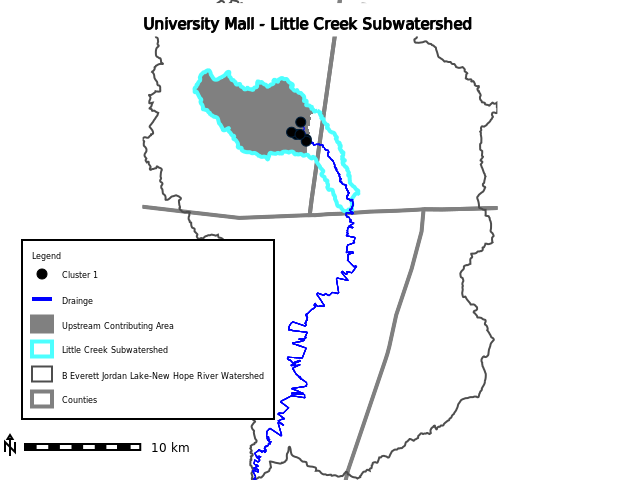

In [458]:
mapCluster(0, title="University Mall - Little Creek Subwatershed")


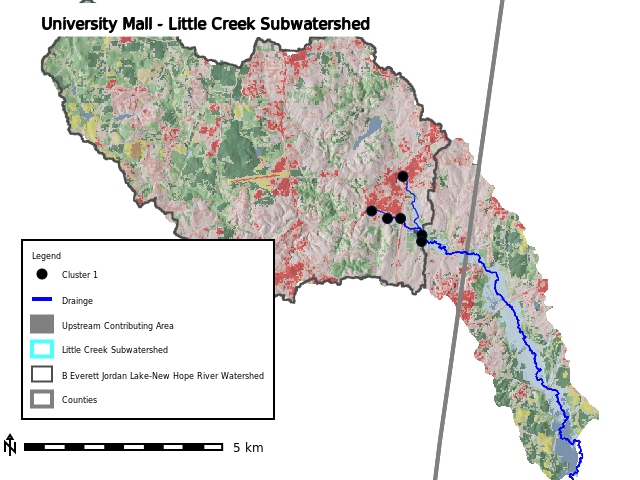

In [478]:
mapClusterUpstream(0, title="University Mall - Little Creek Subwatershed")

In [436]:
landuseTabel("./figures/cluster_1_contrib_landuse.csv")

    landclass                       landuse  cluster  km2            m2  \
0          11                    Open Water       -1  NaN  3.541154e+05   
1          21        Developed (Open Space)       -1  NaN  1.713511e+07   
2          22     Developed (Low Intensity)       -1  NaN  6.548336e+06   
3          23  Developed (Medium Intensity)       -1  NaN  2.595780e+06   
4          24    Developed (High Intensity)       -1  NaN  5.602662e+05   
5          31                   Barren Land       -1  NaN  4.858840e+04   
6          41              Deciduous Forest       -1  NaN  7.985593e+06   
7          42              Evergreen Forest       -1  NaN  5.399111e+06   
8          43                  Mixed Forest       -1  NaN  5.099082e+06   
9          52                   Shrub/Scrub       -1  NaN  2.964292e+05   
10         71          Grassland/Herbaceous       -1  NaN  2.695356e+05   
11         81                   Pasture/Hay       -1  NaN  1.052249e+06   
12         82            

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &        km2 &    percent \\\\\nlanduse\\_group      &            &            \\\\\n\\midrule\nBarren             &   0.048588 &   0.101839 \\\\\nDeveloped          &  26.839491 &  56.254531 \\\\\nForest             &  18.483786 &  38.741299 \\\\\nHerbaceous         &   0.269536 &   0.564936 \\\\\nPlanted/Cultivated &   1.165422 &   2.442679 \\\\\nShrubland          &   0.296429 &   0.621304 \\\\\nWater              &   0.354115 &   0.742212 \\\\\nWetlands           &   0.253439 &   0.531199 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [487]:
cluster_1_elevation_morans = calculateSpatialAutoCorr(variable=dem, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_elevation_morans)

cluster_1_topidx_morans = calculateSpatialAutoCorr(variable=topidx, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_topidx_morans)

cluster_1_inundation_morans = calculateSpatialAutoCorr(variable=inundation, landuse=nlcd_2016, output="cluster_1")
print(cluster_1_inundation_morans)


{'0.9477523': None}
{'0.2080795': None}
{'nan': None}


In [500]:
gs.parse_command("r.univar", map=inundation, flags="g")

{'n': '16512',
 'null_cells': '773234',
 'cells': '789746',
 'min': '0.000213623046875',
 'max': '16.7471008300781',
 'range': '16.7468872070312',
 'mean': '0.946568492771119',
 'mean_of_abs': '0.946568492771119',
 'stddev': '0.889155721274306',
 'variance': '0.790597896674831',
 'coeff_var': '93.9346416096383',
 'sum': '15629.7389526367'}

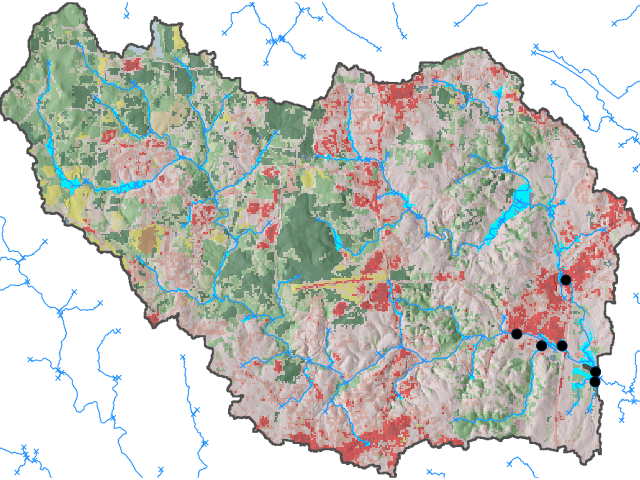

In [497]:
gs.run_command('d.erase')
gs.parse_command('g.region', vector=cluster_contributing_areas[0], res=10, flags='pg')
gs.run_command("r.mask", vector=cluster_contributing_areas[0], overwrite=True)

gs.run_command('d.rast', map=nlcd_2016_blend)
gs.run_command('d.rast', map=inundation)
# gs.run_command("r.colors", map=cluster_contributing_areas[clusterId], rules="./figures/contributing_area_color.txt")
gs.run_command('d.vect', map=cluster_contributing_areas[0],color="77:77:77:255", fill_color="none", width=2)
gs.run_command('d.vect', map=extracted_streams, color="30:144:255:255")

gs.run_command('d.vect', map=cluster_huc10s[0], color="77:77:77:255", fill_color="none", width=2) #"191:191:191:255"
gs.run_command('d.vect', map=cluster_outlets[0], icon="basic/point",fill_color="black", layer=2, size=20)

Image(filename="map.png")

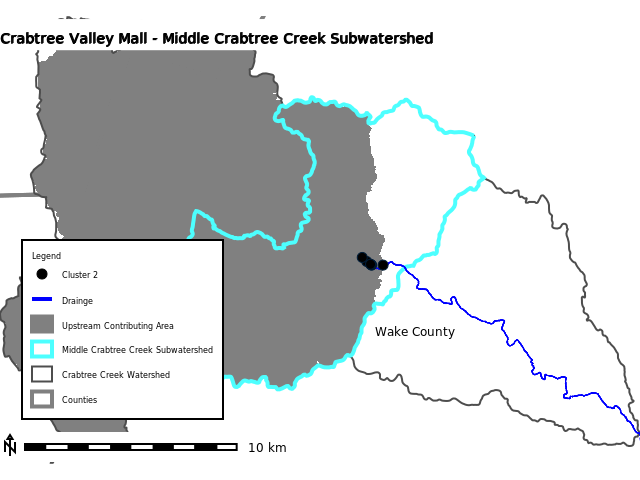

In [445]:
mapCluster(1, title="Crabtree Valley Mall - Middle Crabtree Creek Subwatershed")


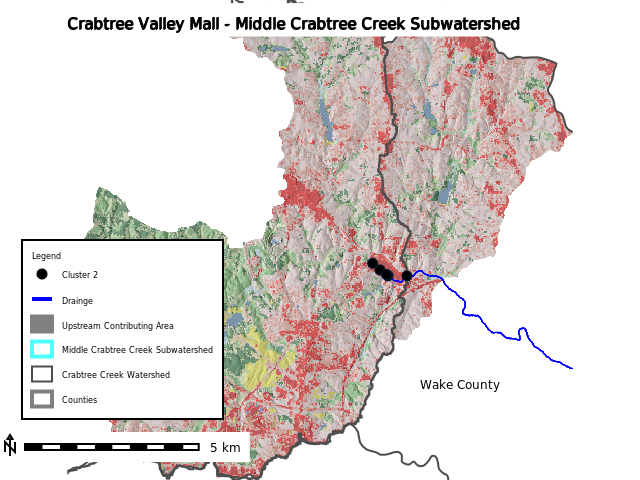

In [476]:
mapClusterUpstream(1, title="Crabtree Valley Mall - Middle Crabtree Creek Subwatershed")

In [443]:
landuseTabel("./figures/cluster_2_contrib_landuse.csv")

    landclass                       landuse  cluster  km2            m2  \
0          11                    Open Water       -1  NaN  7.976309e+05   
1          21        Developed (Open Space)       -1  NaN  2.379179e+07   
2          22     Developed (Low Intensity)       -1  NaN  1.156245e+07   
3          23  Developed (Medium Intensity)       -1  NaN  7.131900e+06   
4          24    Developed (High Intensity)       -1  NaN  1.678523e+06   
5          31                   Barren Land       -1  NaN  1.056011e+06   
6          41              Deciduous Forest       -1  NaN  8.233790e+06   
7          42              Evergreen Forest       -1  NaN  7.632168e+06   
8          43                  Mixed Forest       -1  NaN  9.577168e+06   
9          52                   Shrub/Scrub       -1  NaN  2.621787e+05   
10         71          Grassland/Herbaceous       -1  NaN  5.423490e+05   
11         81                   Pasture/Hay       -1  NaN  2.395491e+06   
12         82            

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &        km2 &    percent \\\\\nlanduse\\_group      &            &            \\\\\n\\midrule\nBarren             &   1.056011 &   1.404618 \\\\\nDeveloped          &  44.164662 &  58.744127 \\\\\nForest             &  25.443126 &  33.842311 \\\\\nHerbaceous         &   0.542349 &   0.721387 \\\\\nPlanted/Cultivated &   2.566912 &   3.414291 \\\\\nShrubland          &   0.262179 &   0.348728 \\\\\nWater              &   0.797631 &   1.060942 \\\\\nWetlands           &   0.348539 &   0.463597 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

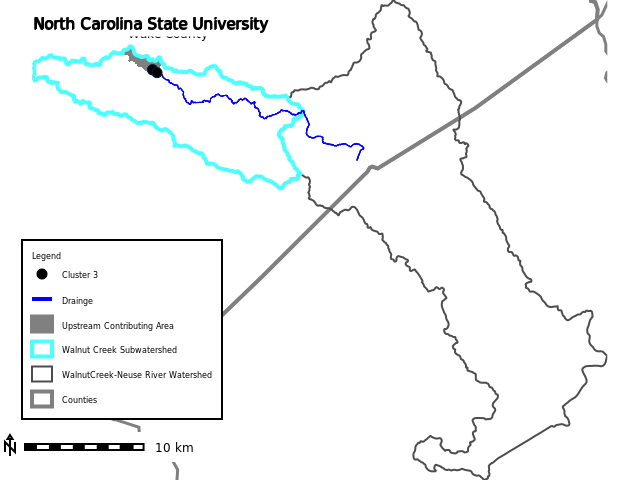

In [447]:
mapCluster(2, title="North Carolina State University")


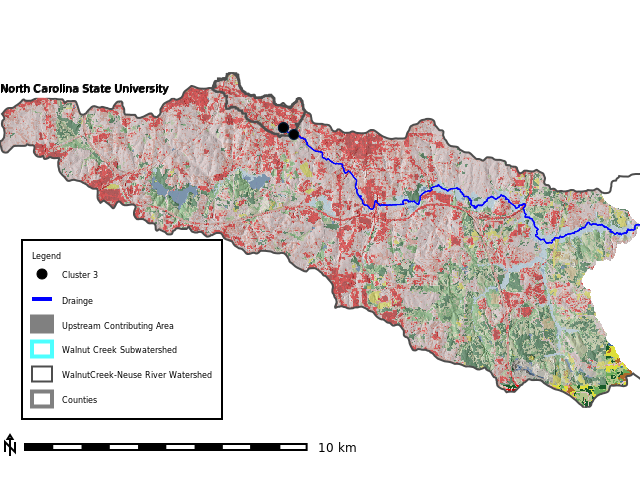

In [474]:
mapClusterUpstream(2, title="North Carolina State University")

In [450]:
landuseTabel("./figures/cluster_3_contrib_landuse.csv")

    landclass                       landuse  cluster  km2             m2  \
0          21        Developed (Open Space)       -1  NaN  667568.204096   
1          22     Developed (Low Intensity)       -1  NaN  945154.982792   
2          23  Developed (Medium Intensity)       -1  NaN  877858.188101   
3          24    Developed (High Intensity)       -1  NaN  253287.936036   
4          31                   Barren Land       -1  NaN   95095.470655   
5          41              Deciduous Forest       -1  NaN   23298.890287   
6          42              Evergreen Forest       -1  NaN    4499.785678   
7          43                  Mixed Forest       -1  NaN    5899.719000   
8          71          Grassland/Herbaceous       -1  NaN    2599.876169   
9          81                   Pasture/Hay       -1  NaN   20699.014117   
10         82              Cultivated Crops       -1  NaN   45397.837726   

    count       landuse_group  
0    6676           Developed  
1    9452           Dev

'\\begin{table}\n\\centering\n\\label{cluster_1_contrib_landuse}\n\\begin{tabular}{lrr}\n\\toprule\n{} &       km2 &    percent \\\\\nlanduse\\_group      &           &            \\\\\n\\midrule\nBarren             &  0.095095 &   3.233044 \\\\\nDeveloped          &  2.743869 &  93.285739 \\\\\nForest             &  0.033698 &   1.145674 \\\\\nHerbaceous         &  0.002600 &   0.088390 \\\\\nPlanted/Cultivated &  0.066097 &   2.247153 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [261]:
def calculateHAND(clusterId, depth=1):
    gs.run_command("r.mask", flags="r")
    # gs.run_command("r.mask", vector=cluster_huc10s[clusterId])
    gs.run_command('g.region', raster=streams, res=10, flags='pg')
    
    above_stream = "above_stream"
    gs.run_command("r.stream.distance", 
        overwrite=True, 
        stream_rast=streams, 
        direction=direction,
        elevation=dem, 
        method="downstream",
        difference=above_stream)
  
    output = "{}m_inundation".format(clusterId + 1, depth)
    gs.run_command("r.lake", overwrite=True, elevation=above_stream, water_level=depth, lake=output, seed=streams)
    return output



In [262]:
inundation = calculateHAND(clusterId=0, depth=1)

In [ ]:
## Wordcloud

# Cluster features or vorroni polygons
# For each cluster calculate convex hull
# For each cluster calculate the weight of each word used in specified field
# Set threshold for word inclusion
# Generate n points in the convex hull 
# Assign each point the word and weight 
# Set the point labels to the word field and the font size to the weight field
# Randomly assign word angle
# Set no colisions

def wordcloud(input, type, layer, output):
    """

    """




In [ ]:
# Read Grass Data into geopandas dataframe
import fiona
import geopandas as gpd

fiona.supported_drivers["OGR_GRASS"] = "r" 
cluster_data = "/home/coreywhite/Documents/grassdata/wrri_nad83_6542/tomorrownow/vector/{}/head".format(clusters[0])
gdf = gpd.read_file(cluster_data)
gdf.head()

In [351]:
# Mask 
gs.parse_command('g.region', vector=research_triangle_huc12, res=10, flags='pg')
gs.run_command("r.mask", flags="r")
gs.run_command("r.blend", first=nlcd_2016, second=hillshade, output=nlcd_2016_blend, flags="c")